# Stock Price prediction

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. 
Unlike standard feedforward neural networks, LSTM has feedback connections. 
It can not only process single data points (such as images), but also entire sequences of data (such as speech or video). --Wikipedia

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. -Stackabuse.com

In this work I used a Bidirectional LSTM to predict the closing stock price of a corporation (Société Générale) using the past 60 day stock price.

In [1]:
#Import the packagages

import math
import pandas_datareader as web
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.backend import clear_session

import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
#Get the stock quote
df = web.DataReader('GLE.PA', data_source='yahoo', start='2010-04-03', end='2020-04-03') # format = 'YYYY-MM-DD'
#Show teh data
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-06-18,18.650000,16.959999,18.450001,17.014999,12178042.0,12.376944
2012-06-19,17.514999,16.500000,17.004999,17.475000,8051765.0,12.711555
2012-06-20,18.000000,17.400000,17.635000,17.975000,6863202.0,13.075262
2012-06-21,18.389999,17.510000,17.719999,17.740000,7646745.0,12.904320
2012-06-22,18.434999,17.395000,17.495001,17.795000,9471589.0,12.944327


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1993 entries, 2012-06-18 to 2020-04-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1993 non-null   float64
 1   Low        1993 non-null   float64
 2   Open       1993 non-null   float64
 3   Close      1993 non-null   float64
 4   Volume     1993 non-null   float64
 5   Adj Close  1993 non-null   float64
dtypes: float64(6)
memory usage: 109.0 KB


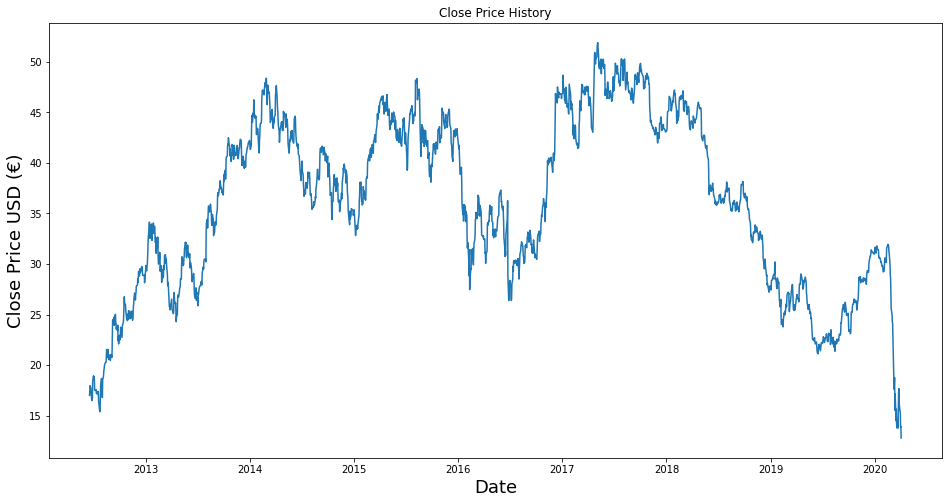

In [4]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD (€)', fontsize=18)
plt.show()

In [5]:
#Create a new dataframe with only the 'Close column
data = df.filter(['Close'])
#Convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = math.ceil( len(dataset) * .8 ) # Length is about 80% of the original data
print("Training data len: ", training_data_len)

Training data len:  1595


In [6]:
#Scale the all of the data to be values between 0 and 1
#In practice it is nearly always advantageous to apply pre-processing transformations/ scaling/ normalization to the input data before it is presented to a network
#Compute the minimum and maximum to be used for later scaling to data, then transform it
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
print(scaled_data)

[[0.10785566]
 [0.11962641]
 [0.13242068]
 ...
 [0.02778914]
 [0.02906857]
 [0.        ]]


In [7]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:training_data_len , :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0]) #The independent training variables or training feature set 'X' (holds the stock price value for the past 60 days at position 'i-60')
  y_train.append(train_data[i, 0])      #The dependent training variables, or target, or training label set 'Y' (holds the stock price at the 61st day at position 'i-60')

#Convert x_train and y_train to numpy arrays so we can use them for training the LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)


#A LSTM network expects the input to be 3-Dimensional in the form [samples, time steps, features]:
# samples is the number of data points (or rows/ records) we have, 
# time steps is the number of time-dependent steps that are there in a single data point (60),
# features/indicators refers to the number of variables we have for the corresponding true value in Y, since we are only using one feature 'Close',
# the number of features/indicators will be one
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print("x_train shape: ", x_train.shape)

x_train shape:  (1535, 60, 1)


In [9]:
clear_session()

#Build the LSTM model
model = Sequential()
#First LSTM layer, input_shape = the number of time steps (60 or x_train.shape[1]) while the last parameter is the number of features (1)
model.add(Bidirectional(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1))))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(50, return_sequences= True)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences= False))
model.add(Dropout(0.2))

model.add(Dense(25))
model.add(Dropout(0.2))

#Output layer
model.add(Dense(1))


#Compile the model
#optimizer = adam and the optimizer is used to improve upon the loss
#loss function = mean_squared_error (MSE) and loss functions are used to measure how well the model did on training
# metrics = mean absolute error (MAE)
#loss=tf.keras.losses.Huber()
optimizer = Adam()
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=["mae"])

#lr_schedule to find the optimal lr 
#lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

#Train the model
history = model.fit(x_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
1535/1535 [==============================] - 21s 14ms/step - loss: 0.0152 - mae: 0.0919
Epoch 2/10
1535/1535 [==============================] - 21s 14ms/step - loss: 0.0059 - mae: 0.0604
Epoch 3/10
1535/1535 [==============================] - 21s 14ms/step - loss: 0.0046 - mae: 0.0527
Epoch 4/10
1535/1535 [==============================] - 21s 14ms/step - loss: 0.0040 - mae: 0.0491
Epoch 5/10
1535/1535 [==============================] - 22s 14ms/step - loss: 0.0030 - mae: 0.0433
Epoch 6/10
1535/1535 [==============================] - 22s 14ms/step - loss: 0.0025 - mae: 0.0392
Epoch 7/10
1535/1535 [==============================] - 22s 14ms/step - loss: 0.0024 - mae: 0.0377
Epoch 8/10
1535/1535 [==============================] - 21s 14ms/step - loss: 0.0018 - mae: 0.0322
Epoch 9/10
1535/1535 [==============================] - 22s 14ms/step - loss: 0.0018 - mae: 0.0325
Epoch 10/10
1535/1535 [==============================] - 22s 14ms/step - loss: 0.0018 - mae: 0.0321


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  20800     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  60400     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
lstm_2 (LSTM)                multiple                  30200     
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1

In [0]:
#Plot learning rate/loss curve for 100 epochs 
#plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
#Create the testing data set
#Create a new array containing scaled values from index 1988 to 2559 
test_data = scaled_data[training_data_len - 60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

#Convert the data to a numpy array
x_test = np.array(x_test)

#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

#Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [12]:
#Get the root mean squared error (RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print("RMSE: ", rmse)

RMSE:  0.7181837123127089


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


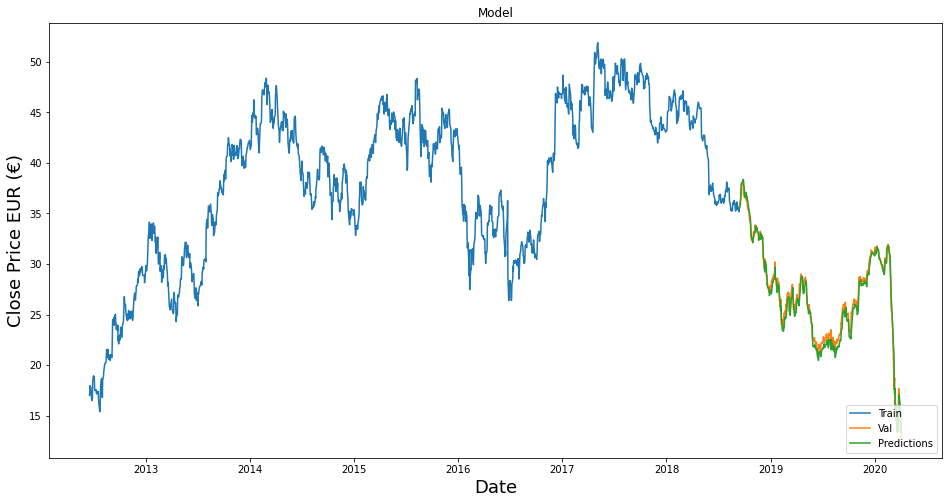

In [16]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price EUR (€)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [14]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2018-09-14,35.810001,35.510498
2018-09-17,36.305000,35.836411
2018-09-18,36.360001,36.340656
2018-09-19,37.160000,36.537918
2018-09-20,37.865002,37.188953
...,...,...
2020-03-30,15.436000,16.189692
2020-03-31,15.348000,15.176599
2020-04-01,13.886000,14.796560


In [17]:
#Get the quote
gle_quote = web.DataReader('GLE.PA', data_source='yahoo', start='2010-04-03', end='2020-04-03')
#Create a new dataframe
new_df = gle_quote.filter(['Close'])
#Get teh last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[12.569752]]


In [23]:
#Get the quote
apple_quote2 = web.DataReader('GLE.PA', data_source='yahoo', start='2020-04-03', end='2020-04-03')
print(apple_quote2['Close'])

Date
2020-04-03    12.8
Name: Close, dtype: float64
